# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load Data

In [2]:
# Dataset 1: Original dataset
edges1 = pd.read_csv('output/prev_kg_edges.csv', header=0)
print(f'Loaded {edges1.shape[0]} edges from dataset 1 with columns:', edges1.columns.values)

nodes1 = pd.read_csv('output/prev_kg_nodes.csv', header=0)
print(f'Loaded {nodes1.shape[0]} nodes from dataset 1 with columns:', nodes1.columns.values)

print('\n')

# Dataset 2: Restructured dataset
edges2 = pd.read_csv('output/new_kg_edges.csv', header=0)
print(f'Loaded {edges2.shape[0]} edges from dataset 2 with columns:', edges2.columns.values)

nodes2 = pd.read_csv('output/new_kg_nodes.csv', header=0)
print(f'Loaded {nodes2.shape[0]} nodes from dataset 2 with columns:', nodes2.columns.values)

Loaded 82944 edges from dataset 1 with columns: ['id' 'subject' 'object' 'relation_id' 'relation_label' 'relation_iri']
Loaded 10034 nodes from dataset 1 with columns: ['id' 'label' 'iri' 'semantic' 'taxon_id' 'taxon_label']


Loaded 85992 edges from dataset 2 with columns: ['id' 'subject' 'object' 'relation_id' 'relation_label' 'relation_iri']
Loaded 10275 nodes from dataset 2 with columns: ['id' 'label' 'iri' 'semantic']


# Create Graph

## Merge nodes with edges

In [3]:
def get_kg(edges: pd.DataFrame, nodes: pd.DataFrame):
    assert 'subject' in list(edges.columns.values)
    assert 'object' in list(edges.columns.values)
    assert 'id' in list(nodes.columns.values)
    
    kg_df = pd.merge(edges, nodes,
                     left_on='subject', right_on='id',
                     how='inner')
    
    kg_df = kg_df.copy()[['id_x', 'subject', 'semantic', 'relation_id', 'relation_label', 'object']]
    kg_df = kg_df.rename(columns={'id_x': 'edge_id', 'subject': 'subject_id', 'semantic': 'subject_class'})
    
    kg_df = pd.merge(kg_df, nodes,
                     left_on='object', right_on='id',
                     how='inner')
    
    kg_df = kg_df.copy()[['edge_id', 'subject_id', 'subject_class', 'relation_id', 'relation_label', 'object', 'semantic']]
    kg_df = kg_df.rename(columns={'object': 'object_id', 'semantic': 'object_class'})
    
    return kg_df

In [4]:
kg_df1 = get_kg(edges1, nodes1)
kg_df1

,edge_id,subject_id,subject_class,relation_id,relation_label,object_id,object_class
0,MONARCH75386,ZFIN:ZDB-GENE-050626-112,ORTH,RO:HOM0000017,in orthology relationship with,FlyBase:FBgn0085464,ORTH
1,MONARCH23115,RGD:1598796,ORTH,RO:HOM0000017,in orthology relationship with,FlyBase:FBgn0085464,ORTH
2,MONARCH70270,ZFIN:ZDB-GENE-000322-6,ORTH,RO:HOM0000017,in orthology relationship with,FlyBase:FBgn0085464,ORTH
3,MONARCH8710,NCBIGene:396067,GENE,RO:HOM0000017,in orthology relationship with,FlyBase:FBgn0085464,ORTH
4,MONARCH80383,dictyBase:DDB_G0277859,GENO,RO:HOM0000017,in orthology relationship with,FlyBase:FBgn0085464,ORTH
...,...,...,...,...,...,...,...
82908,MONARCH39537,dbSNP:rs9975725,GENO,GENO:0000418,has affected feature,ENSEMBL:ENSG00000231236,ORTH
82909,MONARCH64645,dbSNP:rs35396788,GENO,GENO:0000418,has affected feature,HGNC:26832,GENE
82910,MONARCH26352,dbSNP:rs7960954,GENO,GENO:0000418,has affected feature,HGNC:53337,GENE
82911,MONARCH51369,MGI:3531484,ORTH,None,None,MGI:3573782,ORTH


In [5]:
kg_df2 = get_kg(edges2, nodes2)
kg_df2

,edge_id,subject_id,subject_class,relation_id,relation_label,object_id,object_class
0,15a20d1b-1d4c-4ef5-8960-0bbcee1b4261,WormBase:WBGene00006787,gene,RO:0002434,interacts with,WormBase:WBGene00003929,gene
1,7e4c8a99-42a0-4781-97b0-1db60b70611d,WormBase:WBGene00000051,gene,RO:0002434,interacts with,WormBase:WBGene00003929,gene
2,f5df3058-4a07-47b4-88aa-3d176288abf9,WormBase:WBGene00001328,gene,RO:0002434,interacts with,WormBase:WBGene00003929,gene
3,318ad340-8d15-4f97-9e2a-1f24aa6ef5fa,WormBase:WBGene00000042,gene,RO:0002434,interacts with,WormBase:WBGene00003929,gene
4,c08542cd-647f-4ffe-bdcc-d1d8f2a6cd92,FlyBase:FBgn0001250,gene,RO:HOM0000017,in orthology relationship with,WormBase:WBGene00003929,gene
...,...,...,...,...,...,...,...
85987,b7552581fa3d846ace8e6948f4d86664,1906,drug,CustomRO:TTD2,targets,Q8IXJ6,gene product
85988,50e562ac0c69b0126dc686f69de889b9,2966,drug,CustomRO:TTD2,targets,Q8IXJ6,gene product
85989,b039e2951b5993debf77c79470f511b2,1795,drug,CustomRO:TTD2,targets,P02768,gene product
85990,411753776f05434e63ed9f33a9b7aeab,4728,drug,CustomRO:TTD2,targets,P48050,gene product


## Check for duplicates in edges

For dataset 1

In [6]:
assocs1 = pd.read_csv('prev/monarch/monarch_connections_v2023-02-20.csv')
assocs1[assocs1.duplicated(['subject_id', 'object_id', 'relation_label'], keep=False)][['subject_id', 'object_id', 'relation_label']].sort_values(by=['subject_id', 'object_id', 'relation_label'])

,subject_id,object_id,relation_label


In [7]:
kg_df1[kg_df1.duplicated(['subject_id', 'object_id', 'relation_label'], keep=False)]

,edge_id,subject_id,subject_class,relation_id,relation_label,object_id,object_class


For dataset 2, the raw associations fetched from Monarch Initiative already contain duplicates despite havong a different association ID.

In [8]:
assocs = pd.read_csv('output/monarch_associations.csv', header=0)
assocs[assocs.duplicated(['subject_id', 'object_id', 'relation_label'], keep=False)][['id', 'subject_id', 'object_id', 'relation_label']].sort_values(by=['subject_id', 'object_id', 'relation_label'])

,id,subject_id,object_id,relation_label
25742,cc938f17-3373-4a6f-9b61-3172dde2ee76,FlyBase:FBal0002369,MONDO:0010679,has role in modeling
32761,6bf7166d-6ed2-443c-a2ec-56af3d73c85c,FlyBase:FBal0002369,MONDO:0010679,has role in modeling
27384,aec7d719-0aab-4dae-8da7-f56b7399a7dc,FlyBase:FBal0216503,MONDO:0010679,has role in modeling
41956,b1a9848e-c4ed-4704-8e5f-3f1b899477a6,FlyBase:FBal0216503,MONDO:0010679,has role in modeling
25985,76f6d0e3-0430-4cc2-af82-ce602732b06d,FlyBase:FBal0244098,MONDO:0010679,has role in modeling
...,...,...,...,...
74436,72afef59-d66e-4bdb-8667-d152e918fd27,ZFIN:ZDB-FISH-150901-18332,MONDO:0010679,has role in modeling
8492,c831abf6-850f-4667-a927-7ff9acece9a1,ZFIN:ZDB-FISH-150901-25829,MONDO:0010679,has role in modeling
28785,86ecd6c3-9aba-43d1-bc3a-98bee384d5c8,ZFIN:ZDB-FISH-150901-25829,MONDO:0010679,has role in modeling
37466,d2ca266d-ee72-40eb-ae71-2b6154982061,ZFIN:ZDB-FISH-150901-8844,MONDO:0010679,has role in modeling


In [9]:
kg_df2[kg_df2.duplicated(['subject_id', 'object_id', 'relation_label'], keep=False)][['subject_id', 'object_id', 'relation_label']].sort_values(by=['subject_id', 'object_id', 'relation_label'])

,subject_id,object_id,relation_label
11698,FlyBase:FBal0002369,MONDO:0010679,has role in modeling
11699,FlyBase:FBal0002369,MONDO:0010679,has role in modeling
12078,FlyBase:FBal0216503,MONDO:0010679,has role in modeling
12079,FlyBase:FBal0216503,MONDO:0010679,has role in modeling
11770,FlyBase:FBal0244098,MONDO:0010679,has role in modeling
...,...,...,...
12193,ZFIN:ZDB-FISH-150901-18332,MONDO:0010679,has role in modeling
11988,ZFIN:ZDB-FISH-150901-25829,MONDO:0010679,has role in modeling
11989,ZFIN:ZDB-FISH-150901-25829,MONDO:0010679,has role in modeling
11776,ZFIN:ZDB-FISH-150901-8844,MONDO:0010679,has role in modeling


Generate graph objects for both datasets.

In [10]:
def get_graph(edgelist: pd.DataFrame):
    assert 'subject_id' in list(edgelist.columns.values)
    assert 'object_id' in list(edgelist.columns.values)
    assert 'relation_label' in list(edgelist.columns.values)
    assert 'edge_id' in list(edgelist.columns.values)
    
    G = nx.from_pandas_edgelist(edgelist, source='subject_id', target='object_id', edge_attr='relation_label',
                                create_using=nx.DiGraph(), edge_key='edge_id')
    
    for node in G.nodes(data=True):
        print('First node in graph:', node)
        break

    for edge in G.edges(data=True):
        print('First edge in graph:', edge)
        break

    print('Total number of edges is {}'.format(G.number_of_edges()))
    print('Total number of nodes is {}'.format(G.number_of_nodes()))

    return G

In [11]:
print('Dataset 1 graph:')
G1 = get_graph(kg_df1)
print('Dataset 2 graph:')
G2 = get_graph(kg_df2)

Dataset 1 graph:
First node in graph: ('ZFIN:ZDB-GENE-050626-112', {})
First edge in graph: ('ZFIN:ZDB-GENE-050626-112', 'FlyBase:FBgn0085464', {'relation_label': 'in orthology relationship with'})
Total number of edges is 82899
Total number of nodes is 10034
Dataset 2 graph:
First node in graph: ('WormBase:WBGene00006787', {})
First edge in graph: ('WormBase:WBGene00006787', 'WormBase:WBGene00003929', {'relation_label': 'interacts with'})
Total number of edges is 85878
Total number of nodes is 10275


# Plots

In [12]:
def plot_degree_histogram(G, title):
    degree_freq = nx.degree_histogram(G)
    degrees = range(len(degree_freq))

    plt.figure(figsize=(8, 4)) 
    plt.loglog(degrees[3:], degree_freq[3:])
    plt.xlabel('(Log) Degree')
    plt.ylabel('(Log) Frequency')
    plt.title(title)
    plt.show()

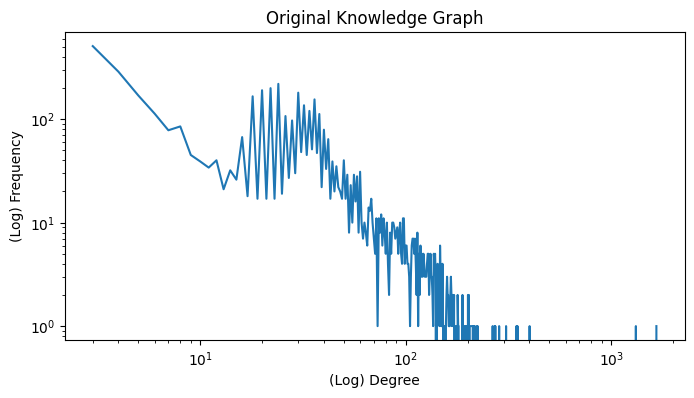

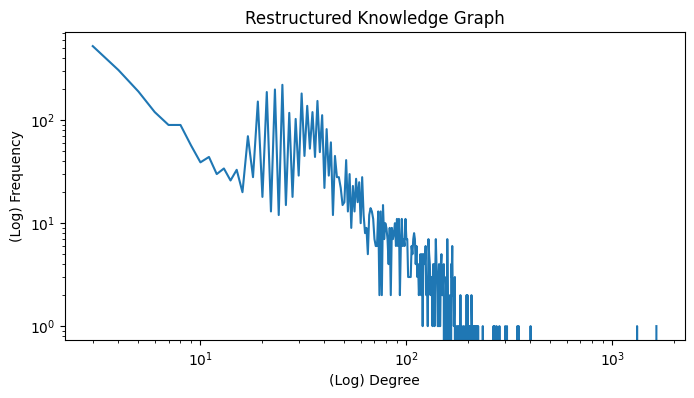

In [13]:
plot_degree_histogram(G1, 'Original Knowledge Graph')
plot_degree_histogram(G2, 'Restructured Knowledge Graph')

# Global Statistics

In [14]:
density_G1 = nx.density(G1)
density_G2 = nx.density(G2)

print('Density of G1:', density_G1)
print('Density of G2:', density_G2)

Density of G1: 0.0008234635549209435
Density of G2: 0.0008135055678780964


In [28]:
clu_G1 = nx.transitivity(G1)
clu_G2 = nx.transitivity(G2)

print('Clustering of G1:', clu_G1)
print('Clustering of G2:', clu_G2)

Clustering of G1: 0.2630752439493588
Clustering of G2: 0.25532128022825534


# Graph Visualization

In [105]:
def get_metagraph(edgelist: pd.DataFrame, dataset: int):
    assert 'object_class' in list(edgelist.columns.values)
    assert 'subject_class' in list(edgelist.columns.values)
    assert 'relation_label' in list(edgelist.columns.values)

    metagraph = edgelist[['object_class', 'subject_class', 'relation_label']]
    metagraph = metagraph.drop_duplicates().reset_index()
    
    G = nx.MultiGraph()
    for ind, edge in metagraph.iterrows():
        G.add_edge(edge['object_class'], edge['subject_class'], edge_label=edge['relation_label'])
    
    if dataset == 1:
        d = {
                'ORTH': 0, 
                'DISO': 1, 
                'GENE': 2, 
                'GENO': 3, 
                'VARI': 4, 
                'ANAT': 5, 
                'DRUG':6 , 
                'PHYS': 7}
        font_color = 'white'
        cmap_name = 'viridis'
    else:
        d = {
                'molecular function': 0, 
                'cellular component': 1, 
                'taxon': 2,
                'biological artifact': 3,
                'gene': 4,
                'genotype': 5,
                'variant': 6,
                'disease': 7,
                'phenotype': 8,
                'biological process': 9,
                'gene product': 10,
                'drug': 11
            }
        font_color = 'black'
        cmap_name = 'Spectral'
    values = [d.get(node, 0.25) for node in G.nodes()]
    
    plt.figure(figsize=(7,7))
    nx.draw(G, cmap=plt.get_cmap(cmap_name), node_color=values, font_color=font_color, font_size=7, with_labels=True, node_size=1600)

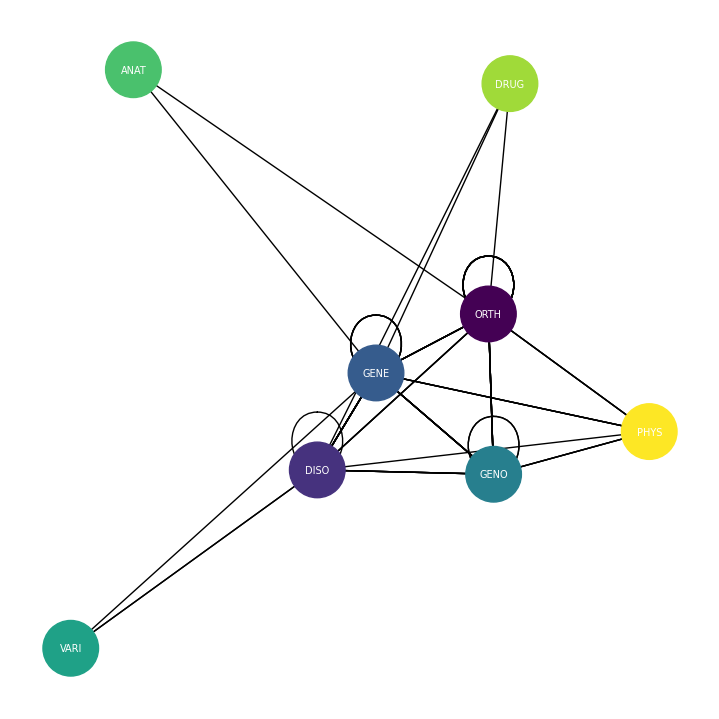

In [106]:
get_metagraph(kg_df1, 1)

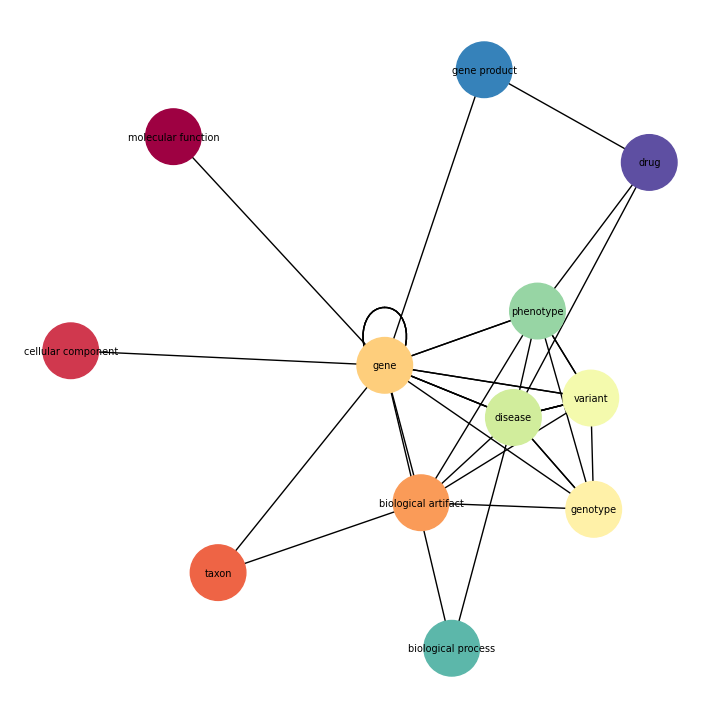

In [107]:
get_metagraph(kg_df2, 2)